In [1]:
from pyEOF import *
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# create a function for visualization convenience
def visualization(da, pcs, eofs_da, evf):
    fig = plt.figure(figsize = (6,12))

    ax = fig.add_subplot(n+1,2,1)
    da.mean(dim=["lat","lon"]).plot(ax=ax)
    ax.set_title("average air temp")

    ax = fig.add_subplot(n+1,2,2)
    da.mean(dim="time").plot(ax=ax)
    ax.set_title("average air temp")

    for i in range(1,n+1):
        pc_i = pcs["PC"+str(i)].to_xarray()
        eof_i = eofs_da.sel(EOF=i)["air"]
        frac = str(np.array(evf[i-1]*100).round(2))

        ax = fig.add_subplot(n+1,2,i*2+1)
        pc_i.plot(ax=ax)
        ax.set_title("PC"+str(i)+" ("+frac+"%)")

        ax = fig.add_subplot(n+1,2,i*2+2)
        eof_i.plot(ax=ax, 
                   vmin=-0.75, vmax=0.75, cmap="RdBu_r", 
                   cbar_kwargs={'label': ""}) 
        ax.set_title("EOF"+str(i)+" ("+frac+"%)")

    plt.tight_layout()
    plt.show()

%matplotlib inline

/opt/anaconda3/envs/pyEOF/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


## load sample data

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)>
[3869000 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]


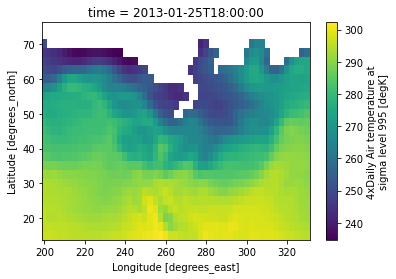

In [2]:
# load the DataArray 
da = xr.tutorial.open_dataset('air_temperature')["air"]
print(da)

# create a mask
mask = da.sel(time=da.time[0])
mask = mask.where(mask<250).isnull().drop("time")

# get the DataArray with mask
da = da.where(mask)
da.sel(time=da.time[99]).plot()
plt.show()

In [3]:
# convert DataArray to DataFrame
df = da.to_dataframe().reset_index() # get df from da
display(df.head(5))
print("DataFrame Shape:",df.shape)

,time,lat,lon,air
0,2013-01-01,75.0,200.0,NaN
1,2013-01-01,75.0,202.5,NaN
2,2013-01-01,75.0,205.0,NaN
3,2013-01-01,75.0,207.5,NaN
4,2013-01-01,75.0,210.0,NaN


DataFrame Shape: (3869000, 4)


## EOF Analysis

### reshape the dataframe to be [time, space]

In [4]:
df_data = get_time_space(df, time_dim = "time", lumped_space_dims = ["lat","lon"])
display(df_data.head(5))
print("DataFrame Shape:",df_data.shape)

air                                                  \
lat                  75.0                                                   
lon                 200.0 202.5 205.0 207.5 210.0 212.5 215.0 217.5 220.0   
time                                                                        
2013-01-01 00:00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2013-01-01 06:00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2013-01-01 12:00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2013-01-01 18:00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2013-01-02 00:00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

                           ...                                      \
lat                        ...        15.0                           
lon                 222.5  ...       307.5       310.0       312.5   
time                       ...                                       
2013-01-01 00:00:00   NaN  ...  299.699982  299.100006  298.699982   
2013-01-01 06:00:00   NaN  ...  299.290009  298.600006  298.199982   
2013-01-01 12:00:00   NaN  ...  299.199982  298.699982  298.790009   
2013-01-01 18:00:00   NaN  ...  300.000000  299.399994  299.100006   
2013-01-02 00:00:00   NaN  ...  299.600006  299.000000  298.790009   

                                                                     \
lat                                                                   
lon                       315.0       317.5       320.0       322.5   
time                                                                  
2013-01-01 00:00:00  298.600006  298.000000  297.790009  297.600006   
2013-01-01 06:00:00  298.100006  297.500000  297.100006  296.899994   
2013-01-01 12:00:00  298.699982  297.899994  297.899994  297.600006   
2013-01-01 18:00:00  299.100006  298.500000  298.600006  298.199982   
2013-01-02 00:00:00  299.000000  298.290009  298.100006  297.699982   

                                                         
lat                                                      
lon                       325.0       327.5       330.0  
time                                                     
2013-01-01 00:00:00  296.899994  296.790009  296.600006  
2013-01-01 06:00:00  296.399994  296.399994  296.600006  
2013-01-01 12:00:00  297.000000  297.000000  296.790009  
2013-01-01 18:00:00  297.790009  298.000000  297.899994  
2013-01-02 00:00:00  297.100006  297.399994  297.399994  

[5 rows x 1325 columns]

DataFrame Shape: (2920, 1325)


### varimax rotated PCA analysis

/opt/anaconda3/envs/pyEOF/lib/python3.7/site-packages/sklearn/utils/extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/anaconda3/envs/pyEOF/lib/python3.7/site-packages/sklearn/utils/extmath.py:709: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs, dtype=np.float64)


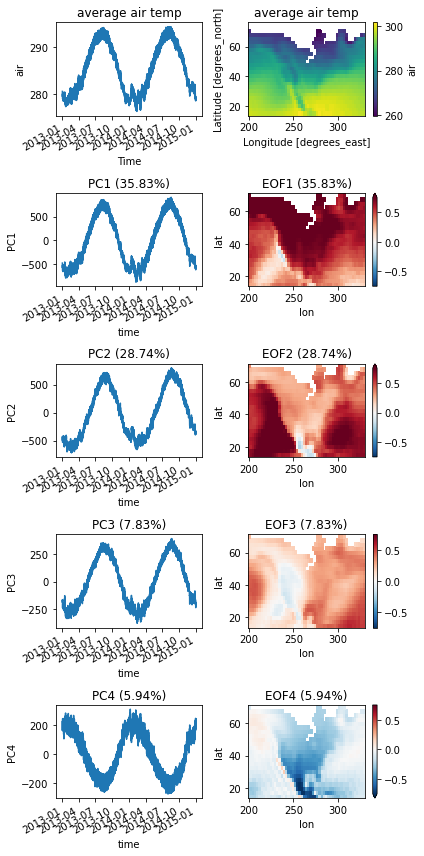

In [5]:
n = 4
pca = df_eof(df_data,pca_type="varimax",n_components=n)

eofs = pca.eofs(s=2, n=n) # get eofs
eofs_da = eofs.stack(["lat","lon"]).to_xarray() # make it convenient for visualization
pcs = pca.pcs(s=2, n=n) # get pcs
evfs = pca.evf(n=n) # get variance fraction
    
# plot
visualization(da, pcs, eofs_da, evfs)

### unrotated EOFs analysis

/opt/anaconda3/envs/pyEOF/lib/python3.7/site-packages/sklearn/utils/extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/anaconda3/envs/pyEOF/lib/python3.7/site-packages/sklearn/utils/extmath.py:709: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs, dtype=np.float64)


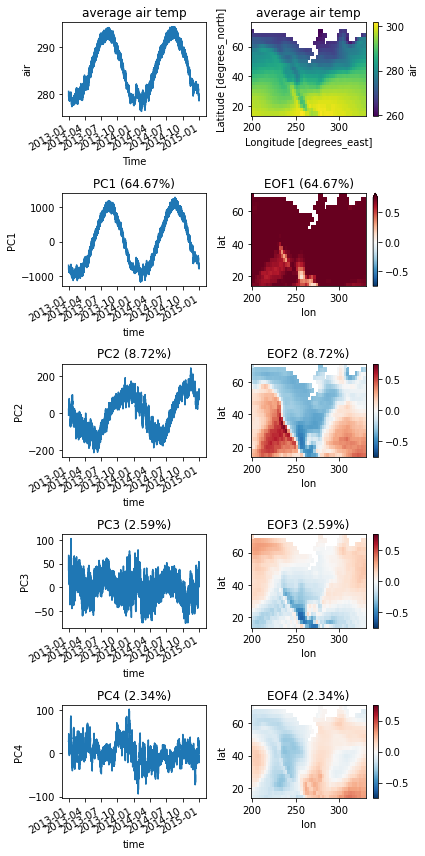

In [6]:
n = 4 # define the number of components

pca = df_eof(df_data) # implement EOF

eofs = pca.eofs(s=2, n=n) # get eofs
eofs_da = eofs.stack(["lat","lon"]).to_xarray() # make it convenient for visualization
pcs = pca.pcs(s=2, n=n) # get pcs
evfs = pca.evf(n=n) # get variance fraction

# plot
visualization(da, pcs, eofs_da, evfs)

## compare with Eofs package (unrotated EOFs)
link: https://ajdawson.github.io/eofs/latest/ 

/opt/anaconda3/envs/pyEOF/lib/python3.7/site-packages/sklearn/utils/extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/anaconda3/envs/pyEOF/lib/python3.7/site-packages/sklearn/utils/extmath.py:709: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs, dtype=np.float64)


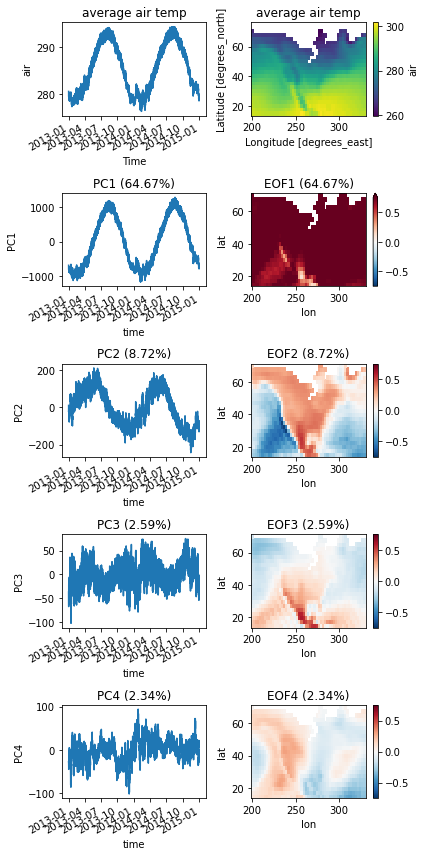

In [7]:
from eofs.standard import Eof
from sklearn.preprocessing import StandardScaler
solver = Eof(StandardScaler().fit_transform(df_data.values))

s_pcs = pd.DataFrame(data=solver.pcs(npcs=4, pcscaling=2),
                     columns = pcs.columns,
                     index = pcs.index)


s_eofs = pd.DataFrame(data = solver.eofs(neofs=4, eofscaling=2),
                      columns = eofs.columns,
                      index = eofs.index)
s_eofs_da = s_eofs.stack(["lat","lon"]).to_xarray() # make it convenient for visualization

s_evfs = solver.varianceFraction(neigs=4)

# plot
visualization(da, s_pcs, s_eofs_da, s_evfs)